## Import Libraries

In [1]:
# Import libraries
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import timeit
import cv2 as cv
from PIL import Image
import imgaug.augmenters as iaa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras import backend as K
import keras_tuner as kt
from keras.models import load_model
import keras
import pydot
keras.utils.vis_utils.pydot = pydot

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import BatchNormalization, AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D,Conv2D,Activation, Dropout, Flatten, Input, Dense

import gradio as gr

In [3]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Metal device set to: Apple M1
Found GPU at: /device:GPU:0


2023-02-17 16:39:35.285306: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-17 16:39:35.286188: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


1/ Load data
2/ Resize
3/ Equalize intensity
4/ Data augmentation

## Data Preprocessing

In [2]:
#2 Image augmentation
augmentation = iaa.Sequential([
    #FLIP
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    #AFFINE
    iaa.Affine(translate_percent={"X": (-0.5,0.5), "y": (-0.4,0.4)},

    rotate=(-30,30),
    scale=(0.5,1.5)),
    #MULTIPLY
    iaa.Multiply((0.8,1.2)),
    # LinearContrast
    iaa.LinearContrast((0.6, 1.4)),
    #Perform methods below only sometimes
    iaa.Sometimes(0.5,
                  #GAUSSIANBLUR
                  iaa.GaussianBlur((0.0,3.0))
                  )


])

In [3]:
#Mettre un graphique
test_breed_list = [
    'n02085620-Chihuahua',
    'n02085782-Japanese_spaniel',
    'n02085936-Maltese_dog',
    'n02086079-Pekinese',
    'n02086240-Shih-Tzu',
    'n02086646-Blenheim_spaniel',
    'n02086910-papillon',
    'n02087046-toy_terrier',
    'n02087394-Rhodesian_ridgeback',
    'n02088094-Afghan_hound',
    'n02088238-basset',
    'n02088364-beagle']

In [4]:
breed_list_150 = ['n02099601-golden_retriever',
                  'n02101556-clumber',
                  'n02102177-Welsh_springer_spaniel',
                  'n02102973-Irish_water_spaniel',
                  'n02104029-kuvasz',
                  'n02105056-groenendael',
                  'n02105162-malinois',
                  'n02106166-Border_collie',
                  'n02106382-Bouvier_des_Flandres',
                  'n02107142-Doberman',
                  'n02109961-Eskimo_dog',
                  'n02110627-affenpinscher',
                  'n02115913-dhole']

In [5]:
import glob
images = []
height = 299
width = 299
dim = (width, height)
labels=[]
start_time = timeit.default_timer()

import random
for index, breed in enumerate(test_breed_list):
    files = list(glob.iglob("Images"+"/"+breed+"/"+"*"))
    for f in files:
        img = Image.open(f)
        img = np.array(img)
        res_img = cv.resize(img, dim, interpolation=cv.INTER_LINEAR)
        images.append(np.array(res_img))
        labels.append(breed.split("-")[1])
        # #data augmentation:
        # augmented_image = augmentation(image=res_img)
        # images.append(np.array(augmented_image))
        # labels.append(breed.split("-")[1])

X = np.array(images)
y = np.array(labels)

preprocess_time = timeit.default_timer() - start_time

print("-" * 50)
print("Execution time for preprocessing :")
print("-" * 50)
print("Number of images preprocessed : {}"\
     .format(len(y)))
print("Shape of images np.array : {}"\
     .format(X.shape))
print("Total time : {:.2f}s".format(preprocess_time))

# images = np.array(images)
# print(format(images))

--------------------------------------------------
Execution time for preprocessing :
--------------------------------------------------
Number of images preprocessed : 2289
Shape of images np.array : (2289, 299, 299, 3)
Total time : 8.02s


In [6]:
# Using np.shuffle
img_space = np.arange(X.shape[0])
np.random.seed(8)
# Shuffle the space
np.random.shuffle(img_space)
# Apply to X and y in same order
X = X[img_space]
y = y[img_space]

In [7]:
# Change X type
X = X.astype(np.float32)
# Encode y text data in numeric
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [8]:
format(y.shape)

'(2289,)'

In [9]:
# Verifie encoder created classes
print(encoder.classes_)

['Afghan_hound' 'Blenheim_spaniel' 'Chihuahua' 'Japanese_spaniel'
 'Maltese_dog' 'Pekinese' 'Rhodesian_ridgeback' 'Shih' 'basset' 'beagle'
 'papillon' 'toy_terrier']


In [ ]:
class_names = encoder.classes_

plt.figure(figsize=(10, 10))

images = []
labels = []
for image in X[0:9]:
    images.append(image)
for label in y[0:9]:
    labels.append(label)

for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype('uint8'), interpolation='nearest')
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Splitting Train and data

In [17]:
### Create train and test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("-" * 50)
print("Size of created sets :")
print("-" * 50)
print("Train set size = ",x_train.shape[0])
print("Test set size = ",x_test.shape[0])

--------------------------------------------------
Size of created sets :
--------------------------------------------------
Train set size =  1831
Test set size =  458


In [71]:
print(np.unique(y))
print(np.unique(y_test))

[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [72]:
format(x_train.shape)

'(1831, 299, 299, 3)'

In [18]:
# Data generator on train set with Data Augmentation
# Validation set is define here
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

#For validation and test, just rescale
test_datagen = ImageDataGenerator(rescale=1./255)

In [19]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Resizing(299, 299),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomCrop(0.1)
])

plt.figure(figsize=(10, 10))
first_image = x_train[0]
print(format(first_image.shape))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## CNN Model 1 - from scratch

In [17]:
model = Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(299, 299, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')
])
model.summary()

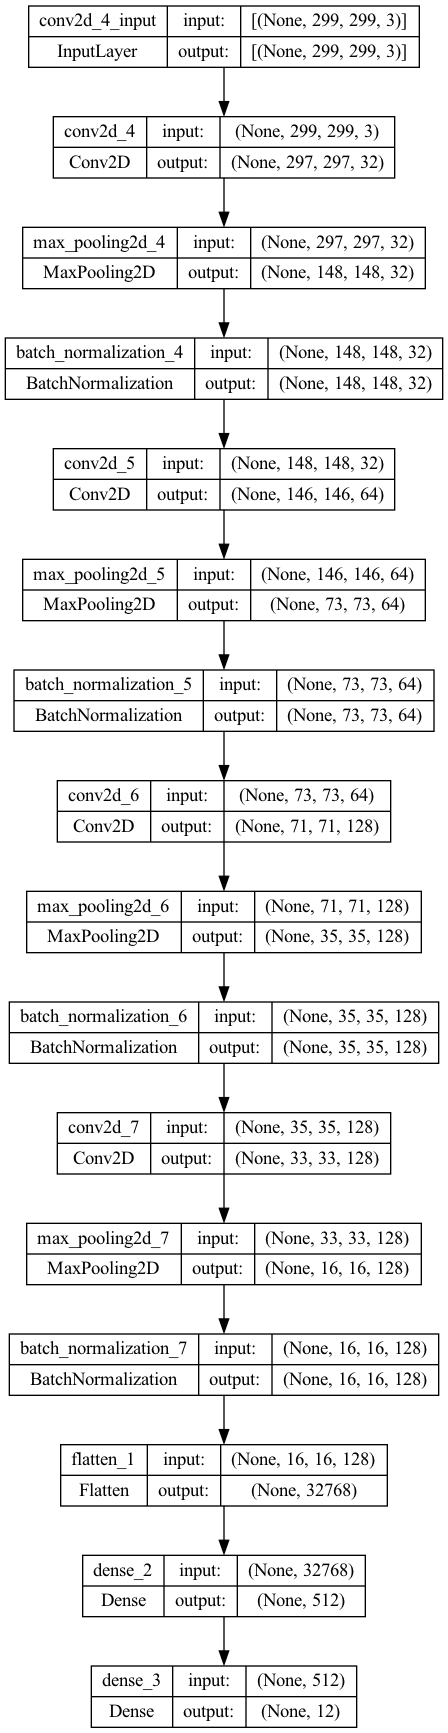

In [18]:
plot_model(model, to_file='CNN_model_plot.png',
           show_shapes=True, show_layer_names=True)

In [19]:
# Compile the CNN Model
from tensorflow.keras.optimizers.legacy import Adam

model.compile(optimizer=Adam(),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", f1_m])

In [ ]:
from sklearn.utils import class_weight
checkpointer = ModelCheckpoint(filepath='models/CNN_model1.hdf5', verbose=1, save_best_only=True)

In [75]:
history = model.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    steps_per_epoch=len(x_train) / 32,
    epochs=20,
    verbose=2,
    callbacks=[checkpointer])

Epoch 1/20


2023-02-17 18:31:59.073415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


57/57 - 64s - loss: 94.6272 - accuracy: 0.1013 - f1_m: 1.1069 - val_loss: 606030.0000 - val_accuracy: 0.1092 - val_f1_m: 0.9437 - 64s/epoch - 1s/step
Epoch 2/20
57/57 - 73s - loss: 15.9215 - accuracy: 0.1175 - f1_m: 3.0793 - val_loss: 127536.3359 - val_accuracy: 0.0644 - val_f1_m: 0.9437 - 73s/epoch - 1s/step
Epoch 3/20
57/57 - 55s - loss: 3.0773 - accuracy: 0.1261 - f1_m: 8.5636 - val_loss: 43313.4609 - val_accuracy: 0.0677 - val_f1_m: 0.9437 - 55s/epoch - 963ms/step
Epoch 4/20
57/57 - 58s - loss: 2.5822 - accuracy: 0.1140 - f1_m: 9.7661 - val_loss: 30901.8926 - val_accuracy: 0.0742 - val_f1_m: 0.9460 - 58s/epoch - 1s/step
Epoch 5/20
57/57 - 43s - loss: 2.5514 - accuracy: 0.1118 - f1_m: 10.9130 - val_loss: 28376.2188 - val_accuracy: 0.0688 - val_f1_m: 0.9437 - 43s/epoch - 754ms/step
Epoch 6/20
57/57 - 53s - loss: 2.4919 - accuracy: 0.1379 - f1_m: 10.3385 - val_loss: 24156.6641 - val_accuracy: 0.0721 - val_f1_m: 0.9437 - 53s/epoch - 928ms/step
Epoch 7/20
57/57 - 58s - loss: 2.4286 - ac

## CNN Model 1 evaluation and visualization

In [77]:
def plot_history_scores(dict_history, first_score, second_score, third_score):
    with plt.style.context('seaborn-whitegrid'):
        fig = plt.figure(figsize=(25,20))
        # summarize history for accuracy
        plt.subplot(2, 2, 1)
        plt.plot(dict_history.history[first_score], color="g")
        plt.plot(dict_history.history['val_' + first_score],
                 linestyle='--', color="orange")
        plt.title('CNN model ' + first_score, fontsize=18)
        plt.ylabel(first_score)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        # summarize history for loss
        plt.subplot(2, 2, 2)
        plt.plot(dict_history.history[second_score], color="g")
        plt.plot(dict_history.history['val_' + second_score],
                 linestyle='--', color="orange")
        plt.title('CNN model ' + second_score, fontsize=18)
        plt.ylabel(second_score)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')

        plt.subplot(2, 2, 3)
        plt.plot(dict_history.history[third_score], color="g")
        plt.plot(dict_history.history['val_' + third_score],
                 linestyle='--', color="blue")
        plt.title('CNN model ' + third_score, fontsize=18)
        plt.ylabel(third_score)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

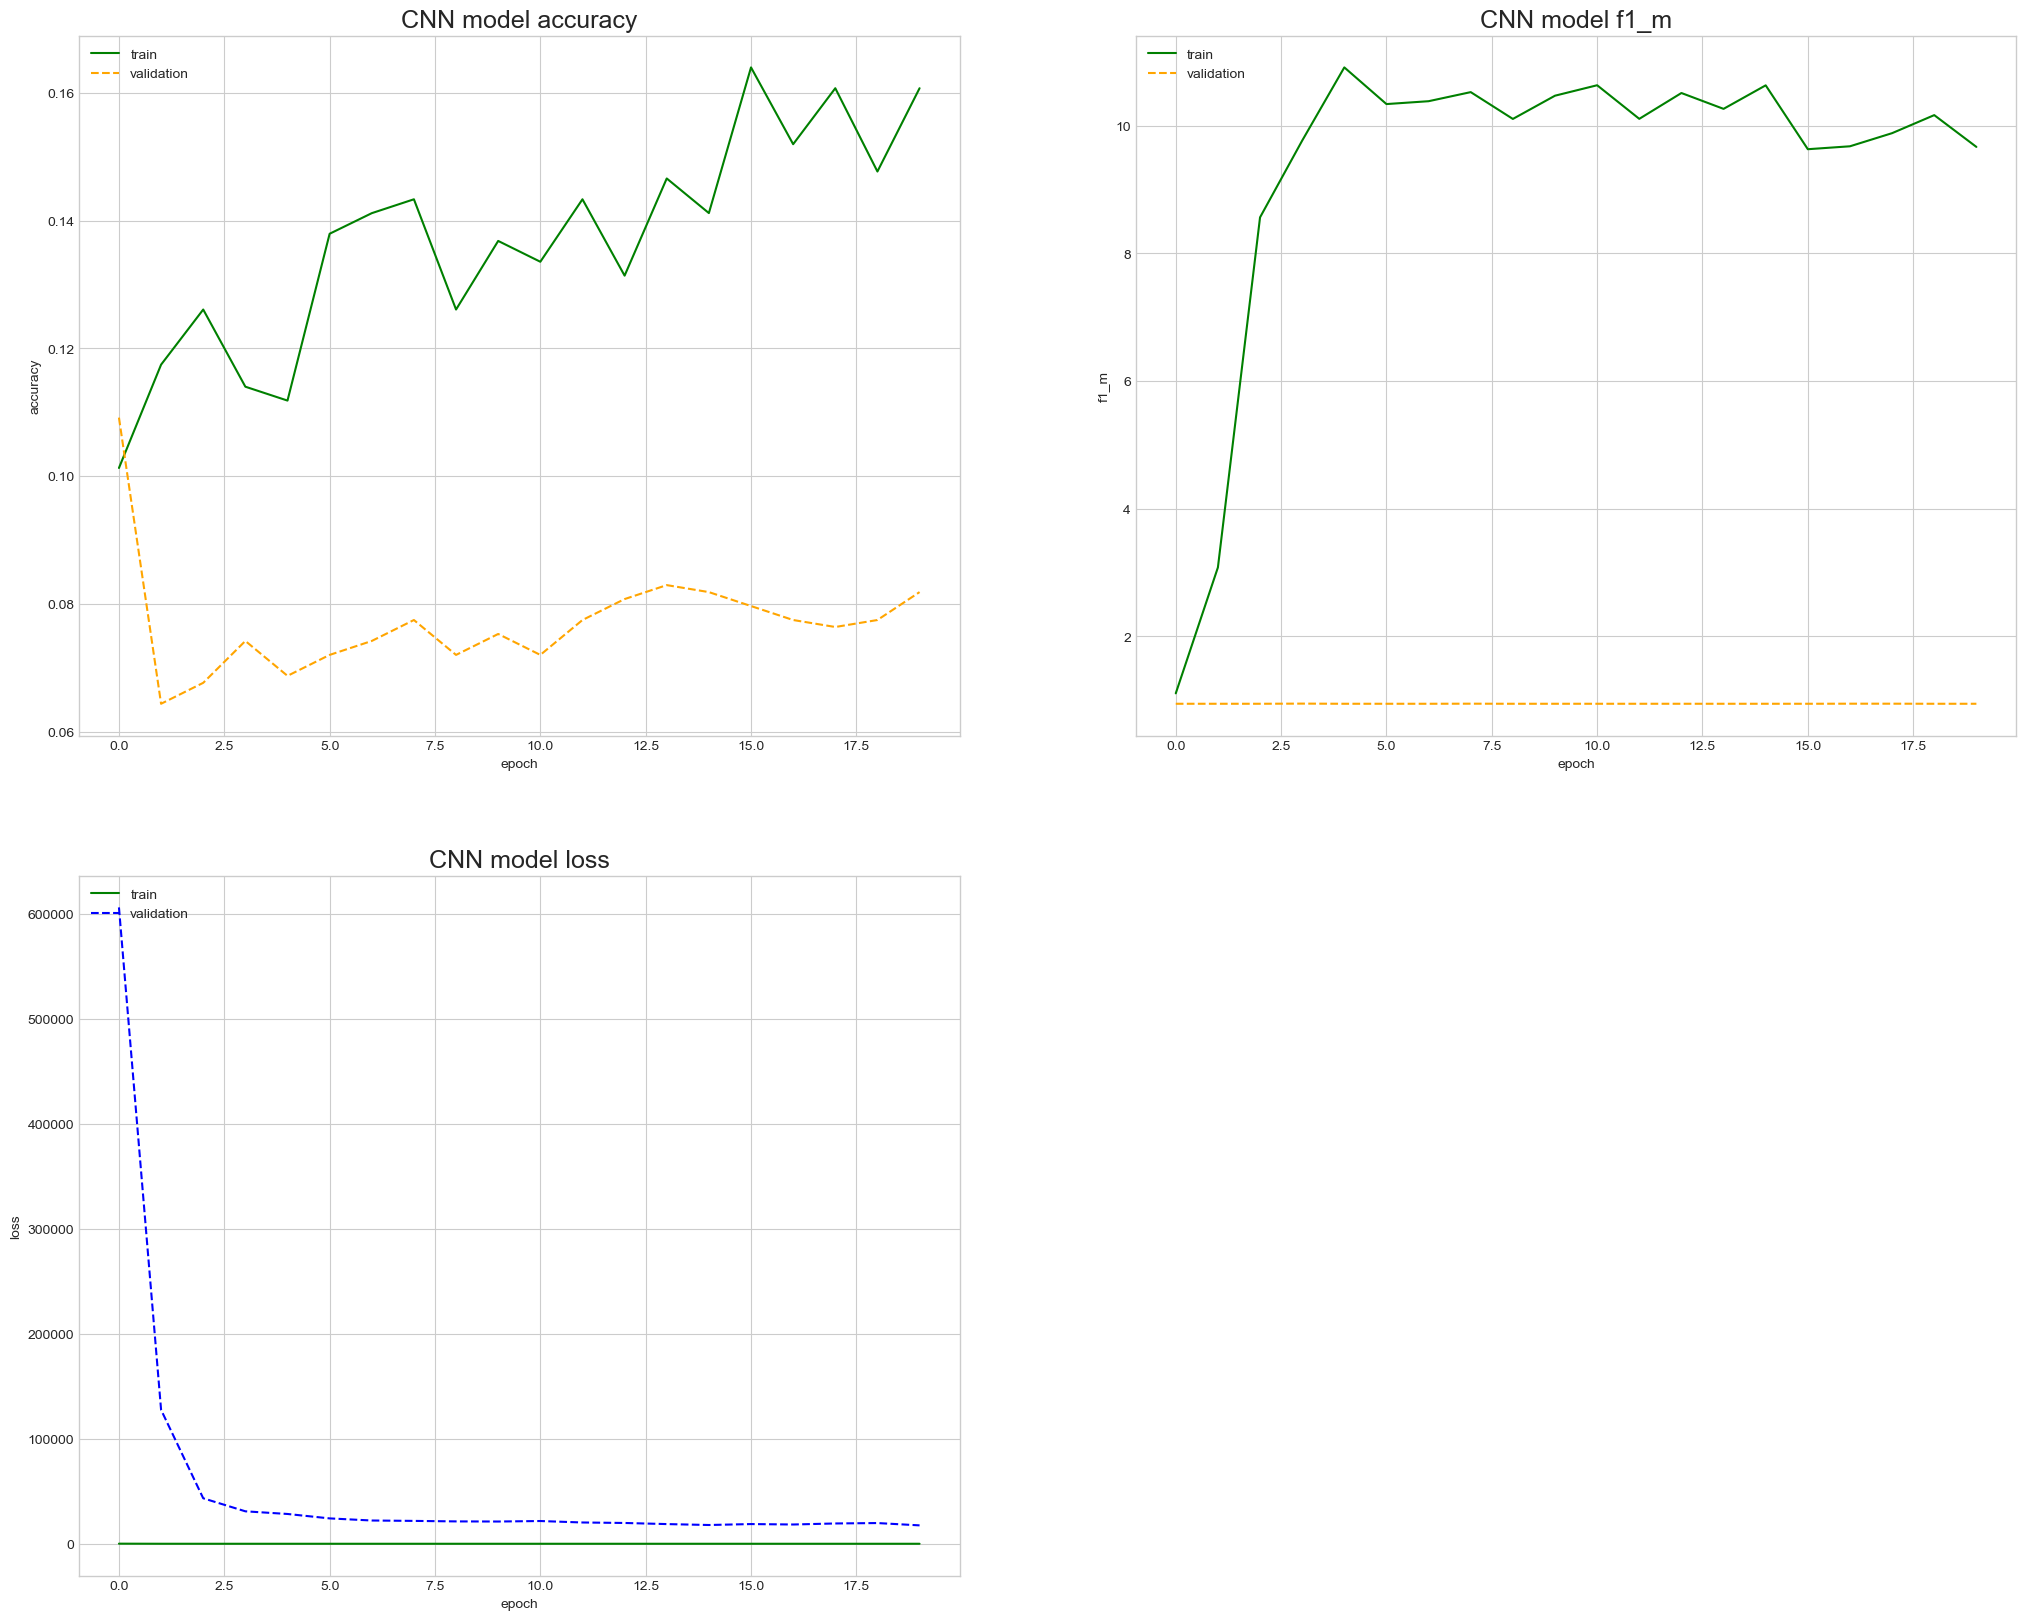

In [78]:
#attention : fixer la fonction
plot_history_scores(
    dict_history = history,
    first_score = "accuracy",
    second_score = "f1_m",
    third_score= "loss"
)

In [ ]:
# evaluer dans un context de production - donnee que ton model va avoir en prod
# monitoring - s'assurer que on rejette - on definit un set de metrics avec des seuils

## CNN Model 2 - from scratch

In [79]:
K.clear_session()
model2 = Sequential([
    #1st conv layer
    Conv2D(filters=32,kernel_size=(5,5),padding='same',input_shape=(299,299,3),kernel_initializer='zeros',bias_initializer=tf.keras.initializers.Constant(0.1), activation='relu'),
    MaxPooling2D(pool_size=(2, 2),strides=(2, 2),padding='valid'),
    BatchNormalization(axis=3,scale=True,gamma_initializer='glorot_normal',momentum=0.99),
    #2nd conv layer
    Conv2D(filters=46,kernel_size=(4,4),padding='same', use_bias=False),
    BatchNormalization(axis=3, scale=False, momentum=0.88),
    #3rd conv layer
    Conv2D(filters=54,kernel_size=(3,3),padding='same',activation='relu'),
    MaxPooling2D(pool_size=(2, 2),strides=(2, 2),padding='valid'),
    BatchNormalization(axis=3,scale=True,gamma_initializer='glorot_normal',momentum=0.7),
    #4th conv layer
    Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu'),
    MaxPooling2D(pool_size=(2, 2),strides=(2, 2),padding='valid'),
    BatchNormalization(axis=3,scale=True,gamma_initializer='glorot_normal',momentum=0.6),
    Dropout(0.05),
    #5th conv layer
    Conv2D(
        filters=64,kernel_size=(3,3),padding='same',use_bias=False, activation='relu'),
    BatchNormalization(axis=3, scale=False, momentum=0.99),
    GlobalAveragePooling2D(keepdims= True, data_format='channels_last'),
    Flatten(),
    tf.keras.layers.Dense(132, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')
])

In [ ]:
plot_model(model2, to_file='CNN_model_plot.png',
           show_shapes=True, show_layer_names=True)

In [80]:
# Compile the CNN Model
from tensorflow.keras.optimizers.legacy import Adam

model2.compile(optimizer=Adam(),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", f1_m])

In [81]:
checkpointer2 = ModelCheckpoint(filepath='models/CNN_model2.hdf5', verbose=1, save_best_only=True)

history2 = model2.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    steps_per_epoch=len(x_train) / 32,
    epochs=20,
    verbose=2,
    callbacks=[checkpointer2])

Epoch 1/20


2023-02-18 18:08:51.407781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-18 18:09:42.799326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 2.48128, saving model to models/CNN_model2.hdf5
57/57 - 63s - loss: 2.4820 - accuracy: 0.1118 - f1_m: 10.0798 - val_loss: 2.4813 - val_accuracy: 0.1148 - val_f1_m: 13.3097 - 63s/epoch - 1s/step
Epoch 2/20

Epoch 2: val_loss improved from 2.48128 to 2.46964, saving model to models/CNN_model2.hdf5
57/57 - 54s - loss: 2.4458 - accuracy: 0.1401 - f1_m: 10.6750 - val_loss: 2.4696 - val_accuracy: 0.1148 - val_f1_m: 13.3436 - 54s/epoch - 939ms/step
Epoch 3/20

Epoch 3: val_loss did not improve from 2.46964
57/57 - 50s - loss: 2.3836 - accuracy: 0.1670 - f1_m: 10.2316 - val_loss: 2.4871 - val_accuracy: 0.1148 - val_f1_m: 12.7981 - 50s/epoch - 876ms/step
Epoch 4/20

Epoch 4: val_loss did not improve from 2.46964
57/57 - 48s - loss: 2.3862 - accuracy: 0.1759 - f1_m: 9.4924 - val_loss: 2.4792 - val_accuracy: 0.1120 - val_f1_m: 13.0575 - 48s/epoch - 837ms/step
Epoch 5/20

Epoch 5: val_loss did not improve from 2.46964
57/57 - 49s - loss: 2.3147 - accuracy: 0

## CNN Model 2 - evaluation and visualization

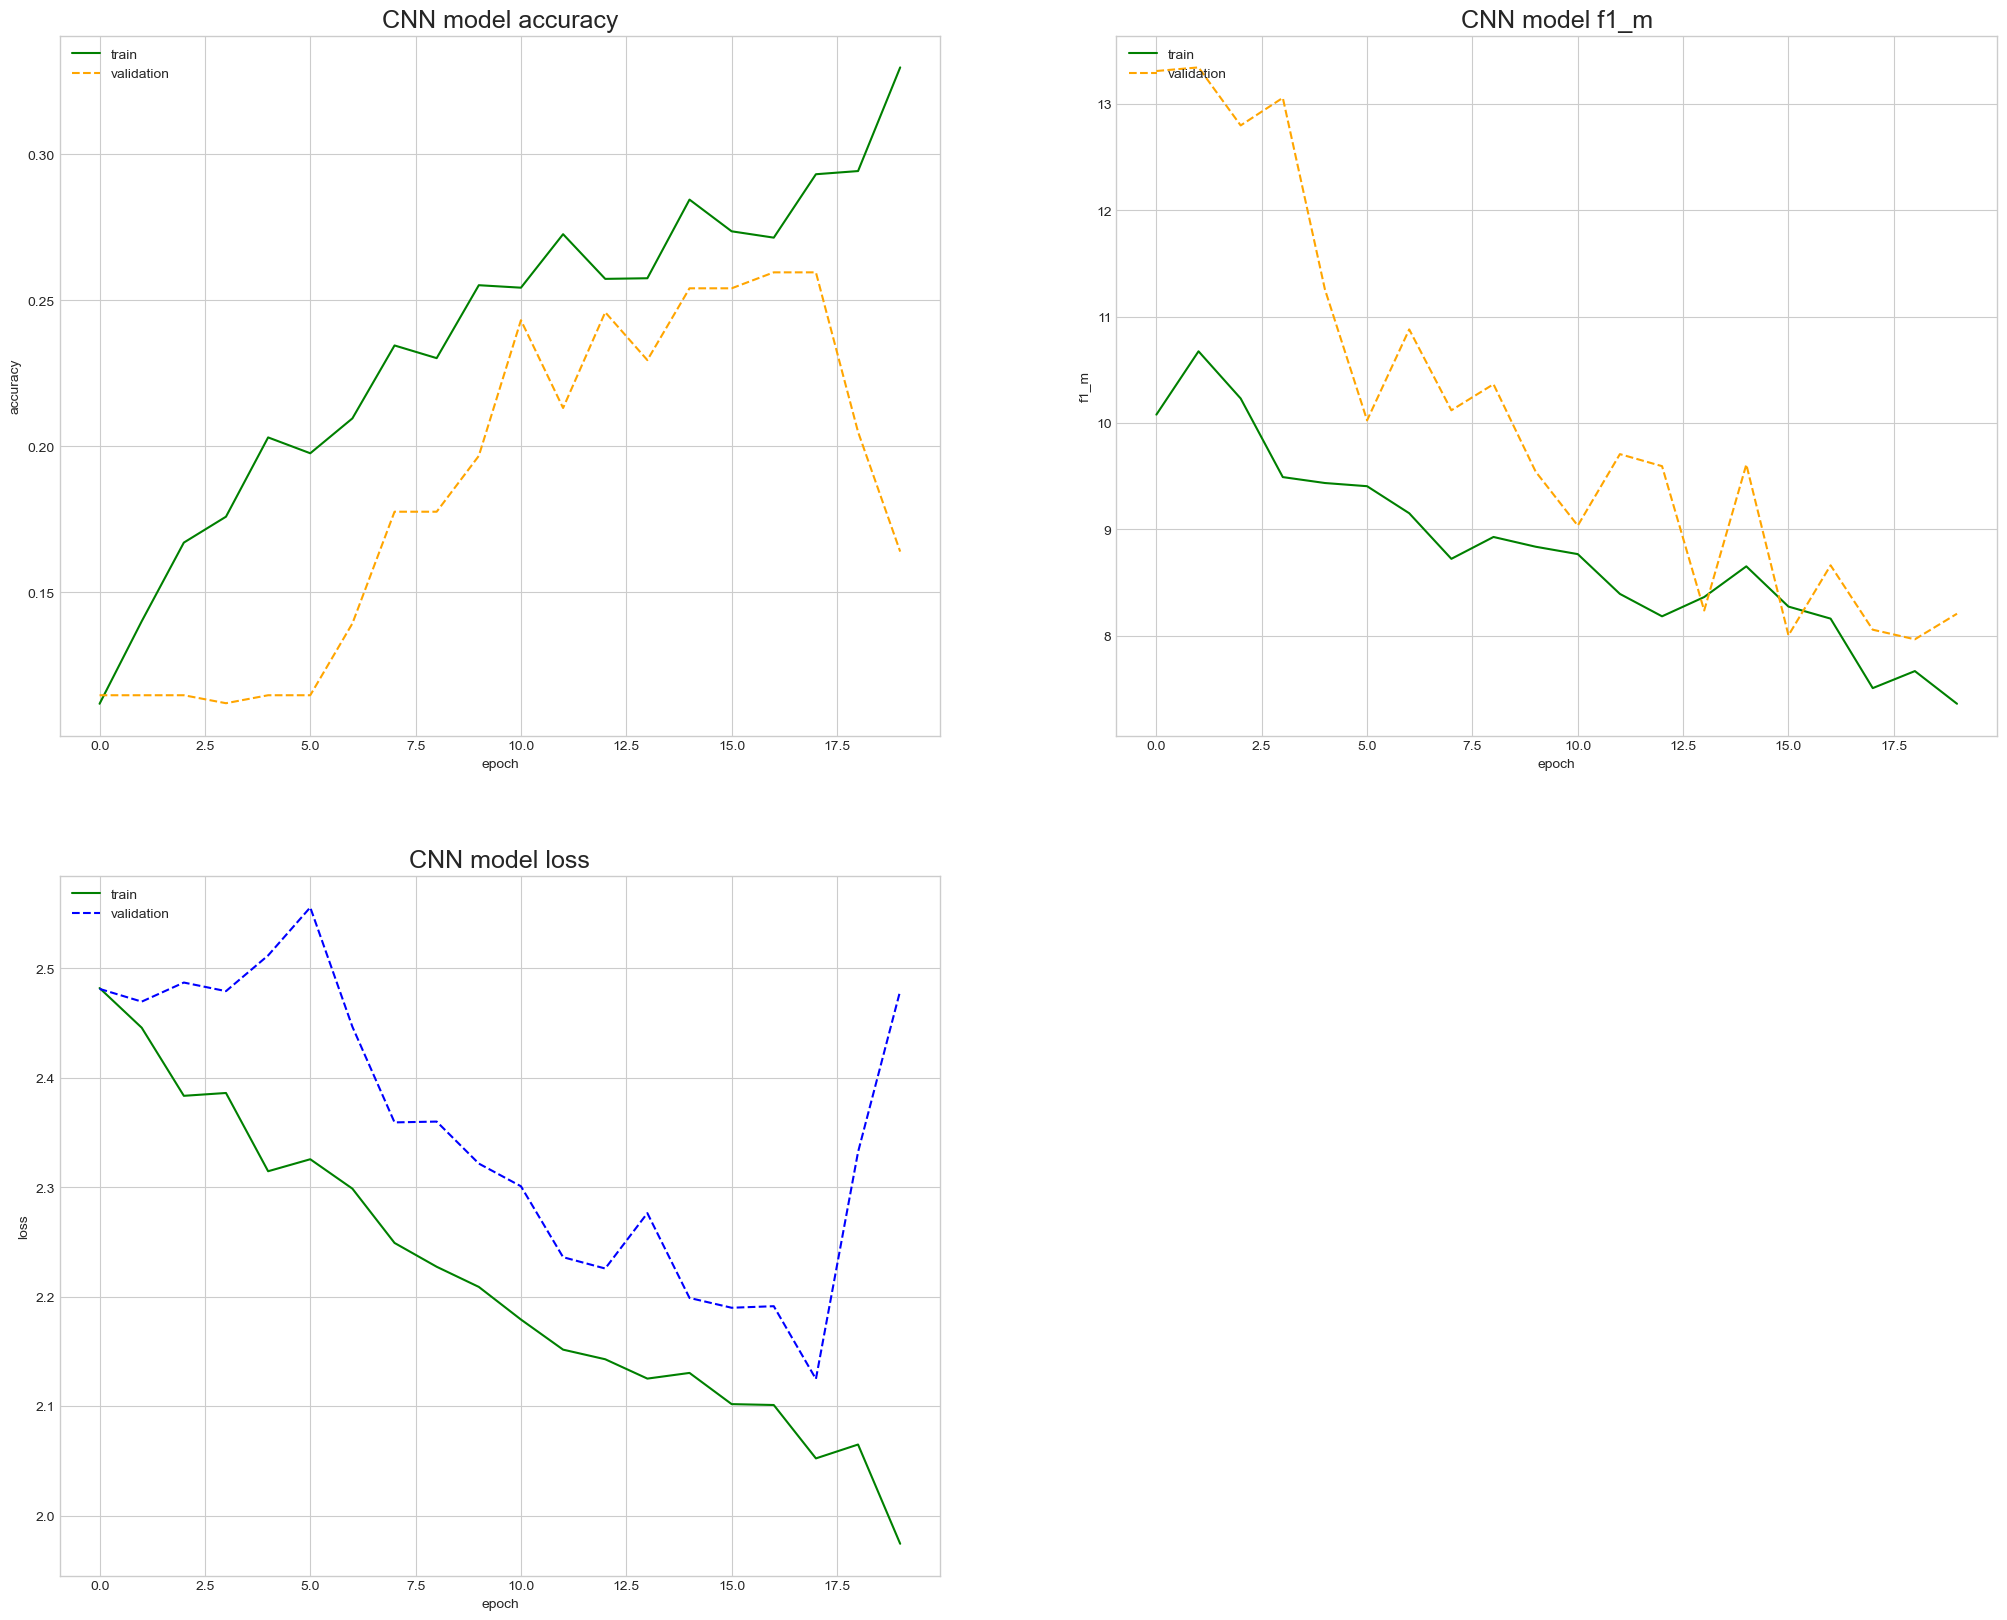

In [82]:
#attention : fixer la fonction
plot_history_scores(
    dict_history = history2,
    first_score = "accuracy",
    second_score = "f1_m",
    third_score= "loss"
)

In [14]:
K.clear_session()
model2_loaded = Sequential([
    #1st conv layer
    Conv2D(filters=32,kernel_size=(5,5),padding='same',input_shape=(299,299,3),kernel_initializer='zeros',bias_initializer=tf.keras.initializers.Constant(0.1), activation='relu'),
    MaxPooling2D(pool_size=(2, 2),strides=(2, 2),padding='valid'),
    BatchNormalization(axis=3,scale=True,gamma_initializer='glorot_normal',momentum=0.99),
    #2nd conv layer
    Conv2D(filters=46,kernel_size=(4,4),padding='same', use_bias=False),
    BatchNormalization(axis=3, scale=False, momentum=0.88),
    #3rd conv layer
    Conv2D(filters=54,kernel_size=(3,3),padding='same',activation='relu'),
    MaxPooling2D(pool_size=(2, 2),strides=(2, 2),padding='valid'),
    BatchNormalization(axis=3,scale=True,gamma_initializer='glorot_normal',momentum=0.7),
    #4th conv layer
    Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu'),
    MaxPooling2D(pool_size=(2, 2),strides=(2, 2),padding='valid'),
    BatchNormalization(axis=3,scale=True,gamma_initializer='glorot_normal',momentum=0.6),
    Dropout(0.05),
    #5th conv layer
    Conv2D(
        filters=64,kernel_size=(3,3),padding='same',use_bias=False, activation='relu'),
    BatchNormalization(axis=3, scale=False, momentum=0.99),
    GlobalAveragePooling2D(keepdims= True, data_format='channels_last'),
    Flatten(),
    tf.keras.layers.Dense(132, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')
])

In [14]:
model2_loaded.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy', f1_m])

In [15]:
model2_loaded.load_weights('models/CNN_model2.hdf5')

In [20]:
loss, acc, f1 = model2_loaded.evaluate(x_test)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [ ]:
#importing random search
from kerastuner import RandomSearch
#creating randomsearch object
tuner = RandomSearch(build_model,
                     objective='val_accuracy',
                     max_trials = 5)
# search best parameter
tuner.search(train_df,train_labl,epochs=3,validation_data=(train_df,train_labl))

## Annexe - code essais

In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator()

train_generator = gen.flow_from_directory(
        '/Users/maurelco/Developer/Python/Projet6/Images_train',  # this is the target directory
        target_size=(299, 299),  # all images will be resized
        color_mode='rgb',
        classes=None,
        batch_size=16,
        shuffle=True,
        seed=None,
        save_to_dir=None,
        save_prefix='',
        class_mode='categorical')
# for image_batch,labels in train_generator:
#         print(image_batch,labels)

In [ ]:
classes = np.unique(y)
class_weights = class_weight.compute_class_weight('balanced', classes= classes, y=y)


In [60]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, verbose=2, callbacks=[checkpointer], steps_per_epoch= len(x_train)/16)

Epoch 1/20


2023-02-17 17:32:30.607057: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-17 17:32:35.735878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-17 17:34:31.020420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 2727.03369, saving model to models/CNN_model1.hdf5
228/228 - 132s - loss: 2.4823 - accuracy: 0.1054 - f1_m: 12.0145 - val_loss: 2727.0337 - val_accuracy: 0.1026 - val_f1_m: 0.9460 - 132s/epoch - 577ms/step
Epoch 2/20

Epoch 2: val_loss did not improve from 2727.03369
228/228 - 116s - loss: 2.4784 - accuracy: 0.1068 - f1_m: 12.0453 - val_loss: 229498.6562 - val_accuracy: 0.1026 - val_f1_m: 0.9437 - 116s/epoch - 507ms/step
Epoch 3/20

Epoch 3: val_loss did not improve from 2727.03369
228/228 - 107s - loss: 2.4761 - accuracy: 0.1100 - f1_m: 11.9829 - val_loss: 6947013.0000 - val_accuracy: 0.1026 - val_f1_m: 0.9437 - 107s/epoch - 469ms/step
Epoch 4/20

Epoch 4: val_loss did not improve from 2727.03369
228/228 - 109s - loss: 2.4749 - accuracy: 0.1100 - f1_m: 12.0252 - val_loss: 23020782.0000 - val_accuracy: 0.1026 - val_f1_m: 0.9437 - 109s/epoch - 477ms/step
Epoch 5/20

Epoch 5: val_loss did not improve from 2727.03369
228/228 - 105s - loss: 2.4741 - 

KeyboardInterrupt: 